In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



In [2]:
data_set = pd.read_csv("../data/Google_Stock_Price_Train.csv")
print(data_set.head())

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


- Data preprocesing

------

In [3]:
data_set.shape

(1258, 6)

In [4]:
data_set = data_set.iloc[:,1:4].values
data_set

array([[325.25, 332.83, 324.97],
       [331.27, 333.87, 329.08],
       [329.83, 330.75, 326.89],
       ...,
       [793.7 , 794.23, 783.2 ],
       [783.33, 785.93, 778.92],
       [782.75, 782.78, 770.41]])

In [5]:
data_set = np.array([[i,j-k]for i,j,k in data_set])
data_set

array([[325.25,   7.86],
       [331.27,   4.79],
       [329.83,   3.86],
       ...,
       [793.7 ,  11.03],
       [783.33,   7.01],
       [782.75,  12.37]])

- Target interval = 1

In [6]:
X_data = data_set[0:1257]
y_data = data_set[1:1258,0:1]

In [7]:
X_sc = MinMaxScaler() # default is 0,1
X_data = X_sc.fit_transform(X_data)

In [8]:
y_sc = MinMaxScaler() # default is 0,1
y_data = y_sc.fit_transform(y_data)

- x_dim =2

In [9]:
X_data

array([[0.08581368, 0.11558367],
       [0.09701243, 0.05673759],
       [0.09433366, 0.03891125],
       ...,
       [0.95163331, 0.16043703],
       [0.95725128, 0.17634656],
       [0.93796041, 0.09929078]])

In [10]:
y_data

array([[0.09701243],
       [0.09433366],
       [0.09156187],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [11]:
# hyperparameters
seq_length =7
batch_size =35
state_size = 4 # hidden node size 
input_dim = X_data.shape[1] # 2
output_dim = y_data.shape[1] # 1

In [12]:
print('# of paired dataset', len(y_data)-seq_length)

# of paired dataset 1250


In [13]:
data_X = []
data_y = []
for i in range(0, len(y_data) - seq_length):
    _X_data = X_data[i:i+seq_length]
    _y_data = y_data[i+seq_length]
    data_X.append(_X_data)
    data_y.append(_y_data)
    if i%1000 ==0:
        print(_X_data, "->", _y_data)

[[0.08581368 0.11558367]
 [0.09701243 0.05673759]
 [0.09433366 0.03891125]
 [0.09156187 0.06248802]
 [0.07984225 0.21084915]
 [0.0643277  0.12631781]
 [0.0585423  0.04389496]] -> [0.06109085]
[[0.88241313 0.16062871]
 [0.87512092 0.0555875 ]
 [0.88138998 0.22311673]
 [0.90700573 0.22465018]
 [0.92544088 0.17002108]
 [0.91223305 0.17883841]
 [0.86293623 0.2102741 ]] -> [0.83875288]


In [14]:
X_trn, X_tst, y_trn, y_tst = train_test_split(data_X, data_y, 
                                              test_size=0.3, 
                                              random_state=42,
                                              shuffle=False
                                              )
print('X_train:', len(X_trn))
print('y_train:', len(y_trn))
print('X_test:', len(X_tst))
print('y_test:', len(y_tst))

X_train: 875
y_train: 875
X_test: 375
y_test: 375


- graph로 통과시킬 변수 선언

In [15]:
tf.reset_default_graph()

In [16]:
X = tf.placeholder(tf.float32, [None, seq_length, input_dim])
y = tf.placeholder(tf.float32, [None, 1])
lr = tf.placeholder(tf.float32)

In [17]:
print(X)
print(y)

Tensor("Placeholder:0", shape=(?, 7, 2), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [18]:
# 0: cell, 1: hidden
init_state = tf.placeholder( tf.float32, [2, None, state_size])
init_state

<tf.Tensor 'Placeholder_3:0' shape=(2, ?, 4) dtype=float32>

- 학습되는 파라미터 선언

In [19]:
# hidden state
# concat trainables weights = state_dim + input dim 
W = tf.get_variable('W_x', shape = (4,input_dim, state_size), 
                    initializer=tf.contrib.layers.xavier_initializer())
U = tf.get_variable('U_h', shape = (4,state_size, state_size), 
                    initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b', shape=[4,state_size], initializer=tf.zeros_initializer())

In [20]:
seq_inputs = tf.transpose(X, [1,0,2])
seq_inputs

<tf.Tensor 'transpose:0' shape=(7, ?, 2) dtype=float32>

In [21]:
h_state, c_state = tf.unstack(init_state)
print(h_state)
print(c_state)

Tensor("unstack:0", shape=(?, 4), dtype=float32)
Tensor("unstack:1", shape=(?, 4), dtype=float32)


$$i = \sigma(\mathbf{W}_i \cdot \mathbf{x}_t + \mathbf{U}_i \cdot \mathbf{h}_{t-1}) + \mathbf{b}_i$$

$$f = \sigma(\mathbf{W}_f \cdot \mathbf{x}_t + \mathbf{U}_f \cdot \mathbf{h}_{t-1}) + \mathbf{b}_f$$

$$o = \sigma(\mathbf{W}_o \cdot \mathbf{x}_t + \mathbf{U}_o \cdot \mathbf{h}_{t-1}) + \mathbf{b}_o$$

$$g = \tanh(\mathbf{W}_g \cdot \mathbf{x}_t + \mathbf{U}_g \cdot \mathbf{h}_{t-1}) + \mathbf{b}_g$$


$$c_t = f \cdot c_{t-1} + i \cdot g$$

$$\mathbf{h}_t = \tanh(c_t) \cdot o$$

```python
cell_outputs = []
hidden_outputs = []

h_state, c_state = tf.unstack(init_state)
for ix in range(seq_inputs.get_shape()[0]):
    # input gate
    i = tf.sigmoid(tf.matmul(seq_inputs[ix], W[0]) + tf.matmul(h_state, U[0]) + b[0] )
    # forget gate
    f = tf.sigmoid(tf.matmul(seq_inputs[ix], W[1]) + tf.matmul(h_state, U[1]) + b[1] )
    # output gate
    o = tf.sigmoid(tf.matmul(seq_inputs[ix], W[2]) + tf.matmul(h_state, U[2]) + b[2] )
    # gate weights
    g = tf.tanh(tf.matmul(seq_inputs[ix], W[3]) + tf.matmul(h_state, U[3]) + b[3] )

    c_state = c_state*f + g*i
    h_state = tf.tanh(c_state) * o
    
    hidden_outputs.append(h_state)
    cell_outputs.append(c_state)
```

---

In [22]:
def RNN_cell(pre_output, x):
    
    h_state, c_state = tf.unstack(pre_output)

    # input gate
    i = tf.sigmoid(tf.matmul(x, W[0]) + tf.matmul(h_state, U[0]) + b[0] )
    # forget gate
    f = tf.sigmoid(tf.matmul(x, W[1]) + tf.matmul(h_state, U[1]) + b[1] )
    # output gate
    o = tf.sigmoid(tf.matmul(x, W[2]) + tf.matmul(h_state, U[2]) + b[2] )
    # gate weights
    g = tf.tanh(tf.matmul(x, W[3]) + tf.matmul(h_state, U[3]) + b[3] )
    
    next_c_state = c_state*f + g*i
    next_h_state = tf.tanh(next_c_state) * o
    
    return tf.stack([next_h_state, next_c_state])

In [23]:
states = tf.scan(RNN_cell, 
                 seq_inputs,
                 initializer=init_state)

In [24]:
# hidden output
tf.unstack(states[:,0,:,:])

[<tf.Tensor 'unstack_1:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_1:1' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_1:2' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_1:3' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_1:4' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_1:5' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_1:6' shape=(?, 4) dtype=float32>]

In [25]:
# cell output
tf.unstack(states[:,1,:,:])

[<tf.Tensor 'unstack_2:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_2:1' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_2:2' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_2:3' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_2:4' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_2:5' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'unstack_2:6' shape=(?, 4) dtype=float32>]

---

In [26]:
last_state = states[-1]
last_state

<tf.Tensor 'strided_slice_2:0' shape=(2, ?, 4) dtype=float32>

In [27]:
# 0: hidden 1: cell
last_h_state = last_state[0]
last_h_state

<tf.Tensor 'strided_slice_3:0' shape=(?, 4) dtype=float32>

In [28]:

# output
V_target = tf.get_variable('V_target', shape=[state_size, output_dim],
                           initializer=tf.contrib.layers.xavier_initializer())

b_target = tf.get_variable('b_target', shape = [1,output_dim],
                           initializer=tf.zeros_initializer())

In [29]:
print(V_target)
print(b_target)

<tf.Variable 'V_target:0' shape=(4, 1) dtype=float32_ref>
<tf.Variable 'b_target:0' shape=(1, 1) dtype=float32_ref>


<br>

- loss function

In [30]:
# with last hidden state
y_pred = tf.layers.dense(last_h_state, output_dim, activation=None)
y_pred

<tf.Tensor 'dense/BiasAdd:0' shape=(?, 1) dtype=float32>

In [31]:
loss = tf.losses.mean_squared_error(labels=y, predictions=y_pred)
train_op = tf.train.AdamOptimizer(lr).minimize(loss)

In [32]:
sess = tf.Session()
init = tf.global_variables_initializer()

In [38]:
sess.run(init)

0th loss: 0.005337675102055073
1000th loss: 0.00026987315504811704
2000th loss: 0.0010962913511320949
3000th loss: 0.00014139153063297272
4000th loss: 0.00013653954374603927
5000th loss: 0.00012812599015887827
6000th loss: 0.0003567672392819077


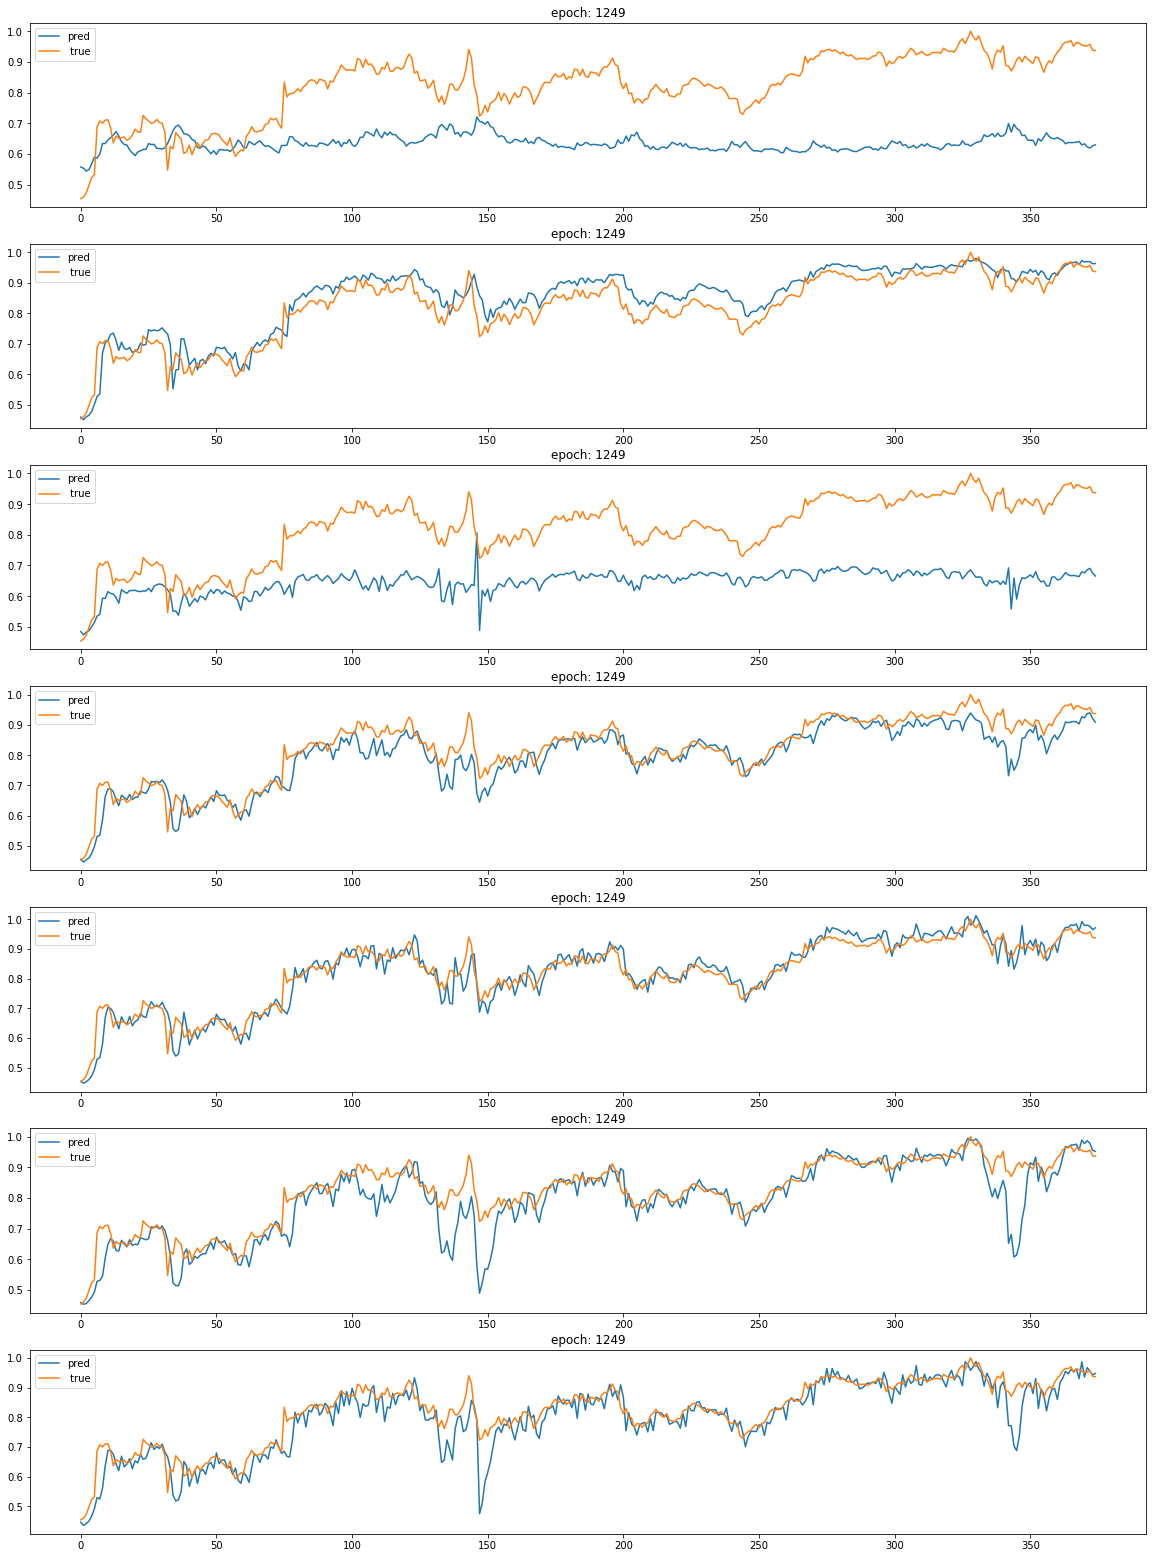

In [39]:
ix=1
plt.figure(figsize=(20,40))
for epoch in range(7000):

    for k in range(math.ceil(len(X_trn)/batch_size)):
        start = k*batch_size
        end = (k*batch_size)+batch_size
        _ , _loss, _current_state = sess.run([train_op, loss, last_state], 
                 feed_dict={lr:0.01,
                            X: X_trn[start:end],
                            y: y_trn[start:end],
                            init_state: np.zeros([2, batch_size, state_size])
                           })

    if epoch % 1000==0:
        print('{}th loss: {}'.format(epoch,_loss))
        
        plt.subplot(10,1,ix)
        
        total_y_pred = []
        for k in range(math.ceil((len(X_tst)/batch_size))):
            start = k*batch_size
            end = (k*batch_size)+batch_size
       
            _y_pred = sess.run(y_pred, feed_dict={ X: X_tst[start:end],
                                                 init_state:_current_state[:,0:len(X_tst[start:end]),:]})
            total_y_pred.extend(_y_pred)
        
        total_y_pred = np.array(total_y_pred)
        
        tst_loss = np.mean(np.abs(total_y_pred-y_tst))
        plt.plot(total_y_pred, label ='pred')
        plt.plot(y_tst, label = ' true')
        plt.legend()
        plt.title('epoch: {}'.format(i))
        
        ix+=1

- y 복원예측하는 방법

In [35]:
y_sc.inverse_transform(_y_pred)[0:5]

array([[875.2185 ],
       [832.4347 ],
       [850.2813 ],
       [757.48834],
       [847.5828 ]], dtype=float32)

In [36]:
tst_loss

0.0755799112434256

In [37]:
y_sc.inverse_transform(tst_loss)

array([[319.74873709]])

---------